In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# fecbo-db完成形

# randomデータ

マニュアル
m,c,a,bの値を設定する．  

fecbo-dbをrandomデータセットに適用し、遠藤教授が提案した評価方法によって分類結果を評価してみる  
よってfecbo-db(m=3,5,8)とfecbo-e(lambda=0.01,0.1)の5種類による結果をcsvファイルに保存することが目的

## 1.fecbo-db(m=3)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
df = pd.read_csv("../dataset/ransuu.csv",header=None)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape

#クラスタ数宣言
c = 5
#Kはクラスタサイズ 
K = X_size /c
#交互最適化最大繰り返し数
max_iter = 100

#ファジィパラメーター設定
m = 3

#初期値繰り返し回数
NumberOfRepetitions= 50

In [3]:
df

,0,1
0,0.932177,0.689336
1,0.892181,0.211903
2,0.619679,0.800032
3,0.442407,0.368525
4,0.151722,0.760419
...,...,...
95,0.949827,0.262254
96,0.113757,0.478405
97,0.933766,0.417087
98,0.001070,0.745300


In [4]:
#uの最適化部分関数作成
def u_optimize(d,c,m):
    #変数定義
    u_list = [0] * len(d)
    for i in range(len(d)):
        u_list[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u_list[i],m)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    Positive_Number = []
    Total_1 = []
    Total_K = []
    constraints = []
    #0以上
    for i in range (len(d)):
        Positive_Number.append(u_list[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        sum_iti = 0
        for j in range(c):    
            sum_iti += u_list[i+j]
        Total_1.append(sum_iti==1)
    
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    for i in range(c-1):
        Total_K.append(sum(u_list[i:len(d):c])==K)
        
    constraints.extend(Positive_Number)
    constraints.extend(Total_1)
    constraints.extend(Total_K)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u_list[i].value)
    u_array = u_value.reshape([X_size,c])
    #u_arrayに帰属度配列、resultに目的関数
    return u_array,result

In [5]:
#クラスタ中心計算部分関数作成
def v_calculation(u_m,c,dimension,X):
    #分母計算(クラスタサイズになるはず)
    v_denominator = np.sum(u_m,axis=0)
    
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u_m[i][j]*X[i]
   
    v = np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/v_denominator[i]
    return v

In [6]:
for s in range (NumberOfRepetitions):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    # kappa,epsilon = CreateEpsilon(a,b,X_size,dimension)       

    for epoch in range(max_iter):
        #print(f"{epoch+1}回目")
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        u,J = u_optimize(d,c,m)
        u_m = u**m
        #vの更新
        new_centroids = v_calculation(u_m,c,dimension,X)

        # もしも重心が変わっていなかったら終了
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            #print(new_centroids-centroids)
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if s == 0:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    elif best_J > J:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    print(f"{s+1}回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

1回目


/Users/kouki/opt/anaconda3/envs/clustering/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1回目のクラスタリング結果↓
0.569480035197798
[[0.43742998 0.29992065]
 [0.74904693 0.7348006 ]
 [0.78542256 0.29798432]
 [0.14119446 0.79857318]
 [0.33425458 0.44748733]]
終了
2回目
中心が変わらないのでbreakします！
2回目のクラスタリング結果↓
0.5603847272565964
[[0.13667771 0.7932675 ]
 [0.7666603  0.27444127]
 [0.28973384 0.32421125]
 [0.4831386  0.55016901]
 [0.8472304  0.74233686]]
終了
3回目
中心が変わらないのでbreakします！
3回目のクラスタリング結果↓
0.5603847272559997
[[0.84723052 0.74233679]
 [0.28973406 0.32421204]
 [0.48313867 0.55016898]
 [0.76666007 0.2744412 ]
 [0.13667769 0.79326743]]
終了
4回目
4回目のクラスタリング結果↓
0.5603847272559997
[[0.84723052 0.74233679]
 [0.28973406 0.32421204]
 [0.48313867 0.55016898]
 [0.76666007 0.2744412 ]
 [0.13667769 0.79326743]]
終了
5回目
5回目のクラスタリング結果↓
0.5603847272559997
[[0.84723052 0.74233679]
 [0.28973406 0.32421204]
 [0.48313867 0.55016898]
 [0.76666007 0.2744412 ]
 [0.13667769 0.79326743]]
終了
6回目
6回目のクラスタリング結果↓
0.5603847272559997
[[0.84723052 0.74233679]
 [0.28973406 0.32421204]
 [0.48313867 0.55016898]
 [0.76666007 0.27

[20. 20. 20. 20. 20.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


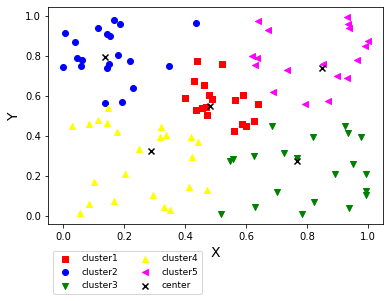

In [7]:
print(np.sum(u, axis=0))#列ごとの総和
print(np.sum(u, axis=1))#行ごとの総和
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
# colors = ['red', 'blue', 'green']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i],alpha=1.0)
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x",alpha = 1.0)
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
#ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

#fig.savefig("iris_m3.pdf",bbox_inches='tight')

##　csvファイルにcluster,U,Jを書き出す

In [8]:
df = pd.read_csv("../dataset/ransuu.csv",header=None)
df

,0,1
0,0.932177,0.689336
1,0.892181,0.211903
2,0.619679,0.800032
3,0.442407,0.368525
4,0.151722,0.760419
...,...,...
95,0.949827,0.262254
96,0.113757,0.478405
97,0.933766,0.417087
98,0.001070,0.745300


In [12]:
#csvファイル書き出しセル
#pandasで分割結果を記入
df["cluster"]=np_cluster
for i in range(c):
    df["u{}".format(i)] = best_u[:,i]
df["J"] = best_J
df.to_csv('Rand-m3.csv',index=False)

In [13]:
test = pd.read_csv("Rand-m3.csv")
test

,0,1,cluster,u0,u1,u2,u3,u4,J
0,0.932177,0.689336,4,9.165617e-02,0.065536,0.132230,0.074655,0.635923,0.560385
1,0.892181,0.211903,2,1.202411e-01,0.074034,0.538621,0.118347,0.148757,0.560385
2,0.619679,0.800032,4,2.326132e-01,0.150636,0.142156,0.128936,0.345659,0.560385
3,0.442407,0.368525,3,2.421726e-01,0.103610,0.179296,0.356890,0.118031,0.560385
4,0.151722,0.760419,1,1.464087e-08,0.809151,0.050700,0.073591,0.066558,0.560385
...,...,...,...,...,...,...,...,...,...
95,0.949827,0.262254,2,1.387005e-01,0.084235,0.469140,0.125935,0.181989,0.560385
96,0.113757,0.478405,3,1.889434e-01,0.244596,0.119549,0.337664,0.109248,0.560385
97,0.933766,0.417087,2,1.541051e-01,0.088980,0.377393,0.123231,0.256291,0.560385
98,0.001070,0.745300,1,1.335240e-01,0.526242,0.089384,0.151836,0.099014,0.560385


In [14]:
#クラスター番号ごとに実際に振り分けられた個数を数える
unique, counts = np.unique(np_cluster, return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4]
[18 20 21 23 18]
